## Imports

In [3]:
import copy
import bisect
import math
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import warnings
import csv
import scipy
from scipy.optimize import fsolve
import random
from collections import defaultdict
import scipy.stats as stats
import scipy.signal
import time
import cProfile
import json
from Bio.PDB import *
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from Bio import BiopythonDeprecationWarning
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq3
from Bio.PDB.Polypeptide import *
import sys
#sys.path.append("../referenceData/miscFunctions")
#import sphereFunctions #from: https://github.com/gjoni/trDesign/blob/master/01-hallucinate/src/utils.py
#import protein #from: https://github.com/sokrypton/ColabDesign/blob/main/colabdesign/shared/protein.py


## Global Variables and Geometric Functions

In [4]:
#Number of bins to partition theta, phi, and R. Note: 0<=R<=Rmax, 0<=theta<2pi, 0<=phi<pi
N_theta=10
N_phi=5
N_R=5

R_max=15
epsilon=.01*R_max #subtract from R_max for assignment
window=5 #discount neighbors within this quantity of index

r_intervals=np.zeros((N_R+1,))
phi_intervals=np.zeros((N_phi+1,))
theta_intervals=np.zeros((N_theta+1,))

V=4*(np.pi/3)*R_max**3

#Look at notes to see where these equations came from 
for i in range(N_R+1):
    r_intervals[i]=((V/N_R)*(3/(4*np.pi))*i)**(1/3)
print(r_intervals)
for i in range(N_theta+1):
    theta_intervals[i]=2*np.pi*i/N_theta
print(theta_intervals)
for i in range(N_phi+1):
    phi_intervals[i]=np.arccos(1-2*i/N_phi)
print(phi_intervals)

[ 0.          8.77205321 11.0520945  12.65148998 13.9247665  15.        ]
[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 6.28318531]
[0.         0.92729522 1.36943841 1.77215425 2.21429744 3.14159265]


In [5]:
#uses binary search to figure out where to place the r,theta,phi in the tuple
#returns indices s.t. it's the left of the left and right values that the number fits between
def determineBin(tup):
    binTup= (bisect.bisect_left(r_intervals,tup[0])-1,bisect.bisect_left(theta_intervals,tup[1])-1,bisect.bisect_left(phi_intervals,tup[2])-1)
    return (max(binTup[0],0), max(binTup[1],0), max(binTup[2],0))

#rotation matrices!
def rotMtxX(angle):
    return np.array([[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])
def rotMtxY(angle):
    return np.array([[np.cos(angle), 0, np.sin(angle)], [0, 1, 0], [-np.sin(angle), 0, np.cos(angle)]])
def rotMtxZ(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0], [np.sin(angle), np.cos(angle), 0], [0, 0, 1]])

#redefining geometric system. returns a rotation matrix that can be applied to a singular point
#C_alpha is origin
#positive Z axis is vector between C_alpha to C_beta,
#N lies on XZ Plane s.t. X is positive
def redefineGeoSystem(C_alpha,C_beta,N):
    C_beta=C_beta-C_alpha
    N=N-C_alpha
    
    angleToXZPlane=np.arctan2(C_beta[1],C_beta[2])
    rotMtx1=rotMtxX(angleToXZPlane)
    
    C_beta=rotMtx1@C_beta
    N=rotMtx1@N
    
    angleToZ=np.arctan2(-C_beta[0],C_beta[2])
    rotMtx2=rotMtxY(angleToZ)
    
    C_beta=rotMtx2@C_beta
    N=rotMtx2@N
    
    angleToXZPlane=np.arctan(-N[1]/N[0])
    angleToXZPlane_alt=np.pi+angleToXZPlane
    
    case=(N[0]*np.cos(angleToXZPlane)-N[1]*np.sin(angleToXZPlane))>0
    
    if case!=True:
        angleToXZPlane=angleToXZPlane_alt
    rotMtx3=rotMtxZ(angleToXZPlane)
    
    return rotMtx3@(rotMtx2@rotMtx1)

#returns r,theta,phi that defines spherical coordinates for cartesian point
# Note: 0<=R<=Rmax, 0<=theta<2pi, 0<=phi<pi
def cartesianToSpherical(point):
    r=np.sqrt(np.sum(np.square(point)))
    theta=np.arctan2(point[1],point[0])
    phi=np.arccos(point[2]/r)
    theta = theta + 2 * np.pi * (np.sign(theta) == -1)
    return (r,theta,phi)

### Variables and Functions for Secondary Structure Assignment

In [ ]:
# THIS IS NEW CLASSIFICATION SYSTEM; SEE 7.17 slides
def classifySecondaryStructure(phi,psi):
    if (-1.47 <= psi) & (psi <= 0.63) & (-2.51 <= phi) & (phi <= -0.42):
        return 'R'
    elif (-0.84 <= psi) & (psi <= 1.26) & (0.63 <= phi) & (phi <= 2.51):
        return 'L'
    elif ((0.63 <= psi) & (psi <= 3.14) & (-np.pi <= phi) & (phi <= -0.42)) or ((-np.pi <= psi) & (psi <= -2.09) & (-np.pi <= phi) & (phi <= -0.84)):
        return 'B'
    return 'X'
        

## functions for neighborhood determination

In [5]:
#for a list x, returns mtx s.t. mtx[i,j] is pairwise distance of x[i] and x[j]
def pw(x):
    '''compute pairwise distance'''
    x_norm = np.square(x).sum(-1)
    xx = np.einsum("...ia,...ja->...ij",x,x)
    sq_dist = x_norm[...,:,None] + x_norm[...,None,:] - 2 * xx
    return np.sqrt(sq_dist+ 1e-10)

def calc_phi_psi(prev_residue, residue, next_residue):
    try:
        C_prev = prev_residue["C"].get_vector()
        
        N = residue["N"].get_vector()
        CA = residue["CA"].get_vector()
        C = residue["C"].get_vector()
        
        N_next = next_residue["N"].get_vector()
        
        phi = calc_dihedral(C_prev, N, CA, C)
        psi = calc_dihedral(N, CA, C, N_next)
        
        return phi, psi 
    except KeyError:
        # Not all residues have all atoms, catch exceptions here
        return 'X','X'
    

#for a protein, returns all CA, CB. -1 if doesn't exist (e.g. Gly)
def getAllPositions(prot1): 
    allCoordCA=[]
    allCoordCB=[]
    allCoordN=[]
    allSecondaryStruct=[]
    fileName='pettilab/shared/structure_comparison_data/protein_data/pdb' + prot1
    p = PDBParser()
    structure = p.get_structure("my_protein", fileName)
    
    for model in structure:
        for chain in model:
            residues=list(chain)
            for i in range(len(residues)):
                residue=residues[i]
                phi='X'
                psi='X'
                if residue.get_resname()!='GLY':
                    try: 
                        allCoordCA.append(np.array(residue['CA'].get_coord()))
                        allCoordCB.append(np.array(residue['CB'].get_coord()))
                        allCoordN.append(np.array(residue['N'].get_coord()))
                    except KeyError:
                        allCoordCA.append('X')
                        allCoordCB.append('X')
                        allCoordN.append('X')
                else:
                    try:
                        allCoordCA.append(np.array(residue['CA'].get_coord()))
                        #copy pasted from: https://github.com/gjoni/trDesign/blob/master/01-hallucinate/src/utils.py
                        #didn't copy function bc idk what was happening there
                        Ca=residue['CA'].get_coord()
                        N=residue['N'].get_coord()
                        C=residue['C'].get_coord()
                        b = Ca - N
                        c = C - Ca
                        a = np.cross(b, c)
                        Cb = -0.58273431*a + 0.56802827*b - 0.54067466*c + Ca
                        allCoordCB.append(np.array(Cb))
                        allCoordN.append(np.array(residue['N'].get_coord()))
                    except KeyError:
                        allCoordCA.append('X')
                        allCoordCB.append('X')
                        allCoordN.append('X')
                if i==0 or i==len(residues)-1:
                    allSecondaryStruct.append('X')
                else:
                    phi, psi = calc_phi_psi(residues[i - 1], residues[i], residues[i + 1])
                    allSecondaryStruct.append(classifySecondaryStructure(phi,psi))
    return allCoordCA, allCoordCB, allCoordN, allSecondaryStruct

#neighborMtx[i,j] 1 if i,j are neighbors, and abs(i-j)>distThreshold.
def closestNeighbors(allCoordCA,distThreshold,adjThreshold):
    dists=pw(allCoordCA)
    neighborMtx = np.where(dists < distThreshold, 1, 0)
    
    for i in range(len(neighborMtx)):
        neighborMtx[i,max(i-adjThreshold,0):(min(i+adjThreshold+1,len(neighborMtx)))]=0
        
    return dists,neighborMtx

#returns list, where each index i is a list of the bins of all the neighbors of amino acid i
def allBinsNeighborsPerProt(prot1):
    allBinsList=[]
    allCoordCA,allCoordCB,allCoordN,allSecondaryStruct=getAllPositions(prot1)
    dists,neighborMtx=closestNeighbors(allCoordCA,R_max-epsilon,window)
    numOfAA=len(dists)
    
    for aa in range(numOfAA):
        neighborBinList=[]
        curNeighborList=neighborMtx[aa,:]
        neighbors=np.where(curNeighborList==1)
        
        C_alpha=allCoordCA[aa]
        C_beta=allCoordCB[aa]
        N=allCoordN[aa]
        rotMtxForAA=redefineGeoSystem(C_alpha,C_beta,N)
        
        for j in neighbors[0]:
            #point needs to be in coord system s.t. C_alpha is origin
            point=allCoordCA[j]-C_alpha
            pointAdjusted=rotMtxForAA@point
            sphericalCoord=cartesianToSpherical(pointAdjusted)
            sphericalBins=determineBin(sphericalCoord)
            binTuple=(j,allSecondaryStruct[j],)+sphericalBins
            neighborBinList.append(binTuple)
        allBinsList.append(neighborBinList)
    return allBinsList
    

# compiling data for all proteins

In [ ]:
#get all Dali Prots
with open ('pettilab/shared/structure_comparison_data/protein_data/dicti_train_val_test.pkl','rb') as file:
    dict_train_test=pickle.load(file)
allProts=list(dict_train_test.keys())

In [ ]:
allProtsBinNeighbors={}
count=0
for prot in allProts:
    count+=1
    allProtsBinNeighbors[prot]=allBinsNeighborsPerProt(prot)
    if count%1000==1:
        print(int(count/1000))

# functions for BLOSUM (Using TM)

In [11]:
# functions that do cigar alignment, but now using a list of indices
def parse_cigar(cigar):
    number = ''
    result = []
    for char in cigar:
        if char.isdigit():
            number += char
        else:
            result.append((char, int(number)))
            number = ''
    return result

def cig_visualizer(start1,start2,cig):
    cig_relevant=parse_cigar(cig)
    index1=start1
    index2=start2
    list1=[]
    list2=[]
    for i in cig_relevant:
        letter=i[0]
        num=i[1]
        if letter=='M':
            list1.extend(np.arange(index1-1,index1+num-1))
            list2.extend(np.arange(index2-1,index2+num-1))
            index1+=num
            index2+=num
        elif letter=='D':
            for j in range(num):
                list1.extend('-')
            list2.extend(np.arange(index2-1,index2+num-1))
            index2+=num
        elif letter=='I':
            for k in range(num):
                list2.extend('-')
            list1.extend(np.arange(index1-1,index1+num-1))
            index1+=num
    return (list1,list2)
#Creates a list of two equal length strings that align corresponding amino acids of two proteins
#based on cigar
def tmAlign_visualizer(tmArr):
    list1=[]
    list2=[]
    ind1=0
    ind2=0
    for indexProtA,i in enumerate(tmArr):
        if i==-1:
            list2.append('-')
            list1.append(indexProtA)
        elif len(list1)==0:
            list1.append(indexProtA)
            list2.append(i)
        elif len(list1)>=0:
            if list2[-1]!='-' and list2[-1]+1!=i:
                for b in range(list2[-1]+1,i):
                    list2.append(b)
                    list1.append('-')
                list2.append(i)
                list1.append(indexProtA)
            else:
                list1.append(indexProtA)
                list2.append(i)
    return (list1,list2)

#like tmAlign_visualizer but specific to the sequence IDs of amino acids
def alignPairTM(tmArr,seq1,seq2):
    list1,list2=tmAlign_visualizer(tmArr)
    res1=[]
    res2=[]
    for a in range(len(list1)):
        if list1[a]!='-':
            res1.append(seq1[list1[a]])
        elif list1[a]=='-':
            res1.append('-')
        if list2[a]!='-':
            res2.append(seq2[list2[a]])
        elif list2[a]=='-':
            res2.append('-')
    return (res1,res2)
            
    
def getIndex(l,value):
    try: 
        return l.index(value)
    except: 
        return -1
    
def neighborMtxMaker(start1,start2,cig,neighborList1,neighborList2):
    templist1,templist2=cig_visualizer(start1,start2,cig)
    list1=[]
    list2=[]
    for i in range(len(templist1)):
        if templist1[i]!='-' and templist2[i]!='-':
            list1.append(templist1[i])
            list2.append(templist2[i])
    dim=len(list1)
    neighborMtx1=[[0 for _ in range(dim)] for _ in range(dim)]
    neighborMtx2=[[0 for _ in range(dim)] for _ in range(dim)]
    for i in range(len(list1)):
        curIndex1=list1[i]
        curIndex2=list2[i]
        rowOfInterest1=neighborList1[curIndex1]
        rowOfInterest2=neighborList2[curIndex2]
        for j in rowOfInterest1:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list1,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx1[i][indexOfNeighborInAdjustedCigarString]=binTup
        for j in rowOfInterest2:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list2,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx2[i][indexOfNeighborInAdjustedCigarString]=binTup
    return neighborMtx1,neighborMtx2


def neighborMtxMakerTM(tmAlgt,neighborList1,neighborList2):
    templist1,templist2=tmAlign_visualizer(tmAlgt)
    list1=[]
    list2=[]
    for i in range(len(templist1)):
        if templist1[i]!='-' and templist2[i]!='-':
            list1.append(templist1[i])
            list2.append(templist2[i])
    dim=len(list1)
    neighborMtx1=[[0 for _ in range(dim)] for _ in range(dim)]
    neighborMtx2=[[0 for _ in range(dim)] for _ in range(dim)]
    for i in range(len(list1)):
        curIndex1=list1[i]
        curIndex2=list2[i]
        rowOfInterest1=neighborList1[curIndex1]
        rowOfInterest2=neighborList2[curIndex2]
        for j in rowOfInterest1:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list1,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx1[i][indexOfNeighborInAdjustedCigarString]=binTup
        for j in rowOfInterest2:
            neighborId=j[0]
            binTup=j[1:]
            indexOfNeighborInAdjustedCigarString=getIndex(list2,neighborId)
            if indexOfNeighborInAdjustedCigarString!=-1:
                neighborMtx2[i][indexOfNeighborInAdjustedCigarString]=binTup
    return neighborMtx1,neighborMtx2


def preprocessFileTM(file,parserDict):
    fileInfo=parseFile_TM(file)
    dataList=[]  
    for key in fileInfo:
        seq1=parserDict[key[0]]
        seq2=parserDict[key[1]]
        tmArr=fileInfo[key]
        dataList.append(alignPairTM(tmArr,seq1,seq2))
    return dataList
        
#parseFile but using TM align
#returns dict: dic[pair]=TM-alignment
def parseFile_TM(fileName):
    fileInfo={}
    with open (fileName,'r') as file:
        reader=csv.reader(file,delimiter=',')
        next(reader)
        for i,row in enumerate(reader):
            try:
                algt_str=row[4]
                algt_str=algt_str.strip('[]')
                algt_str=algt_str.split()
                #algt=list(map(int, algt_str))
                algt=[int(s) for s in algt_str]
                fileInfo[(row[1],row[2])]=algt
            except ValueError:
                print(i)
                print(row)
    return fileInfo
    
def tmAlign_visualizer(tmArr):
    list1=[]
    list2=[]
    ind1=0
    ind2=0
    for indexProtA,i in enumerate(tmArr):
        if i==-1:
            list2.append('-')
            list1.append(indexProtA)
        elif len(list1)==0:
            list1.append(indexProtA)
            list2.append(i)
        elif len(list1)>=0:
            if list2[-1]!='-' and list2[-1]+1!=i:
                for b in range(list2[-1]+1,i):
                    list2.append(b)
                    list1.append('-')
                list2.append(i)
                list1.append(indexProtA)
            else:
                list1.append(indexProtA)
                list2.append(i)
    return (list1,list2)

# Frequency Counts for Aligned Bins

In [5]:
allBins=[]
for a in ['B','L','R','X']:
    for i in range(N_R):
        for j in range(N_theta):
            for k in range(N_phi):
                allBins.append((a,i,j,k))
print(len(allBins))

1000


In [8]:
#reading in relevant files: family!
file='pettilab/shared/structure_comparison_data/protein_data/pairs_training.csv'
fileInfo=parseFile_TM(file)

133155
['e.29', 'd1twfb_', 'd1smyc_', '0.71044', '[-1 -1 -1 ... -1 -1 -1]']
133156
['e.29', 'd1smyc_', 'd1twfb_', '0.69544', '[-1 -1 -1 ... -1 -1 -1]']


In [ ]:

blosumSingleCounts={}
blosumPairCounts={}
totalCount=0
for i in allBins:
    blosumSingleCounts[i]=0
    for j in allBins:
        key=frozenset([i,j])
        blosumPairCounts[key]=0
    blosumPairCounts[frozenset([i,-1])]=0# this corresponds to off the map
blosumSingleCounts[-1]=0 



tCount=1
for key in fileInfo:
    prot1,prot2=key
    tmAlgnmt=fileInfo[key]
    list1,list2=tmAlign_visualizer(tmAlgnmt)
    sphereInfo1=allProtsBinNeighbors[prot1]
    sphereInfo2=allProtsBinNeighbors[prot2]

    resMtx1,resMtx2=neighborMtxMakerTM(tmAlgnmt,sphereInfo1,sphereInfo2)
    dim=len(resMtx1)
    for i in range(dim):
        for j in range(dim):
            binVal1=resMtx1[i][j]
            binVal2=resMtx2[i][j]
            if binVal1!=0 and binVal2!=0:
                binVal1=resMtx1[i][j]
                binVal2=resMtx2[i][j]
                pair=frozenset([binVal1,binVal2])
                blosumPairCounts[pair]+=1
                blosumSingleCounts[binVal1]+=1
                blosumSingleCounts[binVal2]+=1
                totalCount+=1
            elif binVal1!=0 and binVal2==0:
                pair=frozenset([binVal1,-1])
                blosumPairCounts[pair]+=1
                blosumSingleCounts[binVal1]+=1
                blosumSingleCounts[-1]+=1
                totalCount+=1
            elif binVal1==0 and binVal2!=0:
                pair=frozenset([binVal2,-1])
                blosumPairCounts[pair]+=1
                blosumSingleCounts[binVal2]+=1
                blosumSingleCounts[-1]+=1
                totalCount+=1
                
    
    if tCount%10==0:
        print(tCount/10)
    tCount+=1
    totalCountSingle=totalCount*2
    totalCountPairs=totalCount

for key in blosumSingleCounts.keys():
    blosumSingleCounts[key]=blosumSingleCounts[key]/totalCountSingle
for key in blosumPairCounts.keys():
    blosumPairCounts[key]=blosumPairCounts[key]/totalCountPairs

## Constructing Transition Matrix

In [6]:
def genTMtx(blosumSingleCounts,blosumPairCounts):
    mtxIndex=list(blosumSingleCounts.keys())
    binCt=len(mtxIndex)
    pairMtx=np.zeros((binCt,binCt))

    for i in range(binCt):
        curSum=0
        for j in range(i,binCt):
            if not (mtxIndex[i]==-1 and mtxIndex[j]==-1):
                pair=frozenset([mtxIndex[i],mtxIndex[j]])
                pairMtx[i,j]=blosumPairCounts[pair]

    totPairs=0
    for key in blosumPairCounts:
        totPairs+=blosumPairCounts[key]

    f=0.5*pairMtx+0.5*np.transpose(pairMtx)

    #i forget what this is from, prob stationary distribution to validate??
#     c=np.zeros((binCt,1))
#     for i in range(binCt):
#         c[i]=np.sum(pairMtx[i,:])+np.sum(pairMtx[:,i])

#     s=c/(2*np.sum(pairMtx))

    tMtx=np.zeros((binCt,binCt))


    for i in range(binCt):
        rowSum=np.sum(f[i,:])
        for j in range(binCt):
            tMtx[i,j]=f[i,j]/rowSum
    return tMtx


## Validating the -1 bin value

### Am doing this over all of the train proteins only

In [10]:
#get all Dali Prots
with open ('pettilab/shared/structure_comparison_data/protein_data/dicti_train_val_test.pkl','rb') as file:
    dict_train_test=pickle.load(file)
allProts=list(dict_train_test.keys())

In [11]:
trainProts=[]
for prot in allProts:
    if dict_train_test[prot]=='train':
        trainProts.append(prot)

In [12]:
print(len(trainProts))

6506


In [ ]:

s=0
d=0
count=0
tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)
for key in trainProts:

    currentSphere=allProtsBinNeighbors[key]
    length=len(currentSphere)
    vec=np.zeros((length,1001))
    for j in range(length):
        currentAA=currentSphere[j]
        vec[j,:]=np.array(oneHotFromListRowVec(currentAA,mtxIndex))
        
    bv1=np.einsum('ik,kj->ij', vec, tMtx)[:,:-1]
    s+=np.sum(vec)-(np.sum(bv1))
    d+=length
    
    if count%100==0:
        print(f"{count}/{len(trainProts)}")
        print(s/d)
    count+=1

In [32]:
print(allProtsBinNeighbors[trainProts[1000]])

[[(6, 'R', 1, 3, 1), (7, 'R', 2, 2, 1), (8, 'B', 3, 2, 2), (27, 'R', 3, 1, 2), (28, 'R', 1, 1, 2), (29, 'R', 2, 1, 2), (30, 'R', 3, 1, 2), (31, 'R', 1, 1, 2), (32, 'R', 1, 1, 3), (33, 'R', 3, 1, 3), (34, 'R', 3, 0, 3), (35, 'R', 1, 0, 3), (36, 'L', 2, 0, 4), (37, 'R', 0, 1, 4), (38, 'R', 1, 2, 4), (39, 'R', 2, 2, 4), (40, 'R', 1, 3, 4), (41, 'B', 1, 3, 4), (42, 'B', 4, 3, 4), (266, 'R', 4, 9, 1), (267, 'R', 3, 8, 1), (269, 'R', 3, 9, 0), (270, 'R', 1, 9, 0), (271, 'R', 2, 8, 0), (272, 'R', 2, 9, 0), (273, 'R', 1, 0, 0), (274, 'R', 0, 7, 0), (275, 'B', 2, 6, 0), (276, 'B', 2, 4, 0), (277, 'L', 2, 3, 0), (278, 'X', 1, 2, 0), (279, 'B', 2, 1, 0), (285, 'R', 3, 1, 0), (288, 'R', 3, 0, 1), (289, 'R', 2, 0, 1), (290, 'R', 4, 0, 1), (291, 'R', 4, 0, 1), (292, 'R', 2, 0, 1), (293, 'R', 2, 0, 2), (295, 'R', 4, 9, 2), (296, 'R', 2, 9, 2)], [(7, 'R', 1, 4, 4), (8, 'B', 2, 4, 4), (24, 'R', 4, 5, 4), (25, 'R', 3, 5, 4), (26, 'R', 4, 5, 4), (27, 'R', 3, 6, 4), (28, 'R', 1, 6, 4), (29, 'R', 1, 6, 4),

## Creating 1Hot version of allProtSphericalBinsWithSecondaryStruct.pkl

In [ ]:
def getIndex(l,value):
    try: 
        return l.index(value)
    except: 
        return 'e'
    
    
def oneHotFromList(l,mtxIndex):
    binCt=len(mtxIndex)
    oneHot=np.zeros((1,binCt))
    dim=len(l)
    for j in range(dim):
        binVal=l[j][1:]
        ind1=getIndex(mtxIndex,binVal)
        oneHot[0][ind1]+=1
    return oneHot

def oneHotFromListRowVec(l,mtxIndex):
    binCt=len(mtxIndex)
    oneHot=np.zeros((binCt))
    dim=len(l)
    for j in range(dim):
        binVal=l[j][1:]
        ind1=getIndex(mtxIndex,binVal)
        oneHot[ind1]+=1
    return oneHot

with open('../variables/infoDictionaries/sphereSingleCounts.pkl','rb') as f:
    blosumSingleCounts=pickle.load(f)

    
mtxIndex=list(blosumSingleCounts.keys())
binCt=len(mtxIndex)
print(binCt)
print(mtxIndex)

    
    

In [ ]:
allProtsBinNeighbors_1Hot={}
count=0
for key in allProtsBinNeighbors.keys():
    length=len(allProtsBinNeighbors[key])
    vec=np.zeros((length,binCt),dtype=int)
    
    currentSphere=allProtsBinNeighbors[key]
    for j in range(length):
        currentAA=currentSphere[j]
        vec[j,:]=np.array(oneHotFromListRowVec(currentAA,mtxIndex))
        
    vec[:,-1]=5
    allProtsBinNeighbors_1Hot[key]=vec
    if count%100==0:
        print(f"{count}/{11211}")
    count+=1

In [ ]:
with open('allProtSphericalBinsWithSecondaryStruct_nHot.pkl','wb') as f:
    pickle.dump(allProtsBinNeighbors_1Hot,f)
    

## Constructing Transition Matrix

In [13]:
def genTMtx(blosumSingleCounts,blosumPairCounts):
    mtxIndex=list(blosumSingleCounts.keys())
    binCt=len(mtxIndex)
    pairMtx=np.zeros((binCt,binCt))

    for i in range(binCt):
        curSum=0
        for j in range(i,binCt):
            if not (mtxIndex[i]==-1 and mtxIndex[j]==-1):
                pair=frozenset([mtxIndex[i],mtxIndex[j]])
                pairMtx[i,j]=blosumPairCounts[pair]

    totPairs=0
    for key in blosumPairCounts:
        totPairs+=blosumPairCounts[key]

    f=0.5*pairMtx+0.5*np.transpose(pairMtx)

    #i forget what this is from, prob stationary distribution to validate??
#     c=np.zeros((binCt,1))
#     for i in range(binCt):
#         c[i]=np.sum(pairMtx[i,:])+np.sum(pairMtx[:,i])

#     s=c/(2*np.sum(pairMtx))

    tMtx=np.zeros((binCt,binCt))


    for i in range(binCt):
        rowSum=np.sum(f[i,:])
        for j in range(binCt):
            tMtx[i,j]=f[i,j]/rowSum
    return tMtx


# Scoring on Val Set

In [9]:
def jaccardSimFromMtx(A, B):
    # Expand A and B to 3D arrays for broadcasting, aligning them for element-wise minimum calculation
    B=B.T
    A_expanded = A[:, np.newaxis, :]  # Shape becomes (A_rows, 1, A_columns)
    B_expanded = B.T[np.newaxis, :, :]  # Shape becomes (1, B_columns, B_rows)
    
    # Calculate the minimum for each pair of elements from A and B
    min_elements = np.minimum(A_expanded, B_expanded)
    max_elements = np.maximum(A_expanded,B_expanded)
    
    # Sum over the last dimension to get the final result
    result = np.sum(min_elements, axis=2)/np.sum(max_elements, axis=2)
    
    return result



#for a list x, returns mtx s.t. mtx[i,j] is pairwise distance of x[i] and x[j]
def pw(x):
    '''compute pairwise distance'''
    x_norm = np.square(x).sum(-1)
    xx = np.einsum("...ia,...ja->...ij",x,x)
    sq_dist = x_norm[...,:,None] + x_norm[...,None,:] - 2 * xx
    np.fill_diagonal(sq_dist,0)
    return np.sqrt(sq_dist+ 1e-10)


def distMtx(allCoordCA,distThreshold):
    dists=pw(allCoordCA)
    return dists

def reducedDistMtx(alnMtx,distMtx1,distMtx2):
    alnMtx=np.where(alnMtx>0.95,1,0)
    dim=np.sum(alnMtx)
    dim=int(dim)
    redDistMtx1=np.zeros((dim,dim))
    redDistMtx2=np.zeros((dim,dim))
    list1=[]
    list2=[]
    for i in range(np.shape(alnMtx)[0]):
        for j in range(np.shape(alnMtx)[1]):
            if alnMtx[i,j]==1:
                list1.append(i)
                list2.append(j)

    for l in range(len(list1)):
        for k in range(len(list1)):
            redDistMtx1[l,k]=distMtx1[list1[l],list1[k]]
            redDistMtx2[l,k]=distMtx2[list2[l],list2[k]]
    return redDistMtx1,redDistMtx2



def makeRealAln(prot1,prot2):
    start1,start2,cig=fileInfo[(prot1,prot2)]
    cigList1,cigList2=cig_visualizer(start1,start2,cig)
    list0,list1=cig_visualizer(start1,start2,cig)
    alnReal=np.zeros((len(allDaliAARotSequences[prot1]),len(allDaliAARotSequences[prot2])))
    count=0
    for i in range(len(list0)):
        ind1=list0[i]
        ind2=list1[i]
        if ind1!='-' and ind2!='-':
            alnReal[ind1,ind2]=1
            count+=1
    return alnReal

def makeRealAlnMtx_TM(prot1,prot2,fileInfo):
    tmAlgt=fileInfo[(prot1,prot2)]
    list0,list1=tmAlign_visualizer(tmAlgt)
    alnReal=np.zeros((len(allDaliAASequences[prot1]),len(allDaliAASequences[prot2])))
    count=0
    for i in range(len(list0)):
        ind1=list0[i]
        ind2=list1[i]
        if ind1!='-' and ind2!='-':
            alnReal[ind1,ind2]=1
            count+=1
    return alnReal

def jaccardForAlgts(alnFake,alnReal):
    intersec=0
    alnRealQ=np.shape(alnFake)
    for i in range(alnRealQ[0]):
        indFVal='-'
        indRVal='-'
        for j in range(alnRealQ[1]):
            if alnFake[i][j]>0.95:
                indFVal=j
            if alnReal[i][j]>0.95:
                indRVal=j
        if indRVal==indFVal and indRVal!='-':
            intersec+=1
    return (intersec)/(np.sum(alnFake)+np.sum(alnReal)-intersec)
            
    


#does prot1 as ref
def detLDDT(prot1,prot2,aln):
    
    allCoordCA1=allProtCACoord[prot1]
    allCoordCA2=allProtCACoord[prot2]
    
    distMtx1=distMtx(allCoordCA1,15)
    distMtx2=distMtx(allCoordCA2,15)
    
    reducedDistMtx1,reducedDistMtx2=reducedDistMtx(aln,distMtx1,distMtx2)
    
    thresh=[.5,1,2,4]
    threshV=[0,0,0,0]
    
    mask=np.where(reducedDistMtx1<15,1,0)-np.eye(np.shape(reducedDistMtx1)[0])
    
    
    relevantDist=(abs(reducedDistMtx1-reducedDistMtx2))
    for i in range(len(thresh)):
        threshV[i]=np.sum(np.where(relevantDist<thresh[i],1,0)*mask)

            
    denom=4*np.sum(np.where(distMtx1<15,1,0)-np.eye(np.shape(distMtx1)[0]))
    num=np.sum(np.array(threshV))
    
    if denom==0:
        return 0
    return num/denom
                



def genTMtx(blosumSingleCounts,blosumPairCounts):
    mtxIndex=list(blosumSingleCounts.keys())
    binCt=len(mtxIndex)
    pairMtx=np.zeros((binCt,binCt))

    for i in range(binCt):
        curSum=0
        for j in range(i,binCt):
            if not (mtxIndex[i]==-1 and mtxIndex[j]==-1):
                pair=frozenset([mtxIndex[i],mtxIndex[j]])
                pairMtx[i,j]=blosumPairCounts[pair]

    totPairs=0
    for key in blosumPairCounts:
        totPairs+=blosumPairCounts[key]

    f=0.5*pairMtx+0.5*np.transpose(pairMtx)

    c=np.zeros((binCt,1))
    for i in range(binCt):
        c[i]=np.sum(pairMtx[i,:])+np.sum(pairMtx[:,i])

    s=c/(2*np.sum(pairMtx))

    tMtx=np.zeros((binCt,binCt))


    for i in range(binCt):
        rowSum=np.sum(f[i,:])
        for j in range(binCt):
            tMtx[i,j]=f[i,j]/rowSum
    return tMtx




def getLDDT(sim_mtx,lens,tMtx):
    lddtMax=0
    for j in goodSchemesAri:
        a,b,o=j
        aln = my_affine_sw_func(a*(sim_mtx-b), (lens[0][0],lens[0][1]), gap=-1,open=o*(-1),temp=.001)
        aln=np.array(aln)
        lddt=detLDDT(pair[0],pair[1],aln)
        if lddt>lddtMax:
            lddtMax=lddt
    return lddtMax


In [49]:
# LDDT Function
def simMtxBV(pair,tMtx):
    
    sphereInfo1=allProtsBinNeighbors_1Hot[pair[0]]
    sphereInfo2=allProtsBinNeighbors_1Hot[pair[1]]
    
    bv1=np.einsum('ik,kj->ij', sphereInfo1, tMtx)[:,:-1]
    bv2=np.einsum('ik,kj->ij', sphereInfo2, tMtx)[:,:-1]

    simMtx=jaccardSimFromMtx(bv1,bv2)
    
    len1=np.shape(sphereInfo1)[0]
    len2=np.shape(sphereInfo2)[0]
    lens=np.array([[len1,len2]])
    lens=jnp.array(lens)
    
    return (simMtx,lens)

# Store Transition Matrix

In [ ]:
tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)

np.save('transition_matx.npy',tMtx)

# For SW/Local algt

In [8]:
import sw_functions as sw
import numpy as np
import jax #https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
import jax.numpy as jnp
import os
import json
import csv

# Relevant for SW/local alignment stuff:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/10.1.243-fasrc01/"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
my_sw_func = jax.jit(sw.sw(batch=False))
my_affine_sw_func = jax.jit(sw.sw_affine(batch=False))
my_nw_func = jax.jit(sw.nw(batch=False))

#### Determine the best schema using gridsearch for scale/shift (fix gap pen at -1)


In [51]:
aff=np.array([1,4,7,10,13])
mult=np.array([20,25,30,35,40])
shift=np.array([.2,.25,.3,.35,.4])
#form: mult,shift,aff
schemes=[]
for m in mult:
    for s in shift:
        for a in aff:
            schemes.append((m,s,a))

In [56]:
def pickBestScheme(pairsList,fileInfo):
    tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)
    schemeQual=np.zeros(len(schemes))
    for j in range(len(pairsList)):
        if j%100==0:
            print(f"{j}/{len(pairsList)}")
        pair=pairsList[j]
        schemeListPerPair=np.zeros(len(schemes))
        sim_mtx,lens=simMtxBV(pair,tMtx)
        alnReal=makeRealAlnMtx_TM(pair[0],pair[1],fileInfo)
        for i in range(len(schemes)):
            mult,shift,aff=schemes[i]
            aln = my_affine_sw_func(mult*(sim_mtx-shift), (lens[0][0],lens[0][1]), gap=-1,open=aff*(-1),temp=.001)
            schemeListPerPair[i]=detLDDT(pair[0],pair[1],aln)
            #schemeListPerPair[i]=jaccardForAlgts(aln,alnReal)
        best=np.max(schemeListPerPair)
        goodSchemesArr = np.where(schemeListPerPair >= best*.9, 1, 0)
        goodSchemesArr=goodSchemesArr/np.sum(goodSchemesArr)
        schemeQual+=goodSchemesArr
    return schemes[np.argmax(schemeQual)]

In [53]:
valFile='pettilab/shared/structure_comparison_data/protein_data/pairs_validation.csv'
valFileInfo=parseFile_TM(valFile)
pairList=list(valFileInfo.keys())
print(len(pairList))

2900


In [54]:
with open('pettilab/shared/structure_comparison_data/protein_data/allDaliAASequences.json', 'r') as file:
    allDaliAASequences = json.load(file)

In [55]:
with open('pettilab/shared/structure_comparison_data/protein_data/allProtCACoord.pkl', 'rb') as file:
    allProtCACoord = pickle.load(file)

In [ ]:
print(pickBestScheme(pairList,valFileInfo))

### Plot Prep

In [70]:
def plotLDDTs(lddtReal,lddtMe,title):
    lddtMe=np.array(lddtMe)
    lddtReal=np.array(lddtReal)
    line=1*lddtReal+0

    plt.scatter(lddtReal,lddtMe,color='blue',s=3)
    plt.plot(lddtReal, line)
    #ax.axline((0,0),slope=1)
    plt.title(title)
    plt.xlabel('lddt Dali')
    plt.ylabel('lddt Us')
    plt.xlim(.3,1)
    plt.ylim(0.3,1)
    plt.show()

In [60]:
def sabaNumCalc(lddtR,lddtOther):
    s=0
    l=len(lddtR)
    for i in range(l):
        for j in range(i+1,l):
            if np.sign(lddtR[i]-lddtR[j])==np.sign(lddtOther[i]-lddtOther[j]):
                s+=1
    return (s/(l*(l-1)/2))
    
            

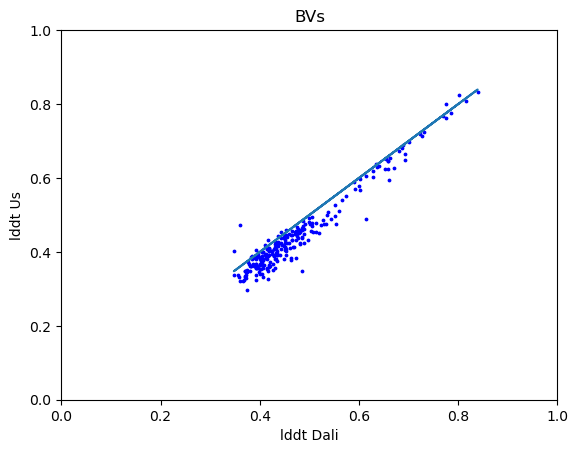

For Us: mean: 0.4442651131766197, std: 0.10652184946181323, sabaNum: 0.880995983935743
For Real: mean: 0.4725856267999703, std: 0.10061917786314
(30, 0.35, 10)


In [68]:
tMtx=genTMtx(blosumSingleCounts,blosumPairCounts)

#first find best scheme
goodScheme=pickBestScheme(pairList[0:100],valFileInfo)
lddtReal=[]
lddtUs=[]
for pair in pairList[0:250]:
    alnReal=makeRealAlnMtx_TM(pair[0],pair[1],valFileInfo)
    mult,shift,aff=goodScheme
    sim_mtx,lens=simMtxBV(pair,tMtx)
    alnMade=my_affine_sw_func(mult*(sim_mtx-shift), (lens[0][0],lens[0][1]), gap=-1,open=aff*(-1),temp=.001)
    lddtReal.append(detLDDT(pair[0],pair[1],alnReal))
    lddtUs.append(detLDDT(pair[0],pair[1],alnMade))
title="BVs"
plotLDDTs(lddtReal,lddtUs,title)
print(f"For Us: mean: {np.mean(lddtUs)}, std: {np.std(lddtUs)}, sabaNum: {sabaNumCalc(lddtReal,lddtUs)}")
print(f"For Real: mean: {np.mean(lddtReal)}, std: {np.std(lddtReal)}")
print(goodScheme)
